##Importing necessary packages

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Triple Channel Attention Block

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")



# Define custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, data_dir, class_labels, transform=None):
        self.data_dir = data_dir
        self.class_labels = class_labels
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through each class folder and collect image paths and labels
        for class_label in class_labels:
            class_dir = os.path.join(data_dir, class_label)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.png')):  # Ensure image formats
                    self.image_paths.append(os.path.join(class_dir, filename))
                    self.labels.append(class_labels.index(class_label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label



class CustomClassifier(nn.Module):
    def __init__(self, num_classes, in_channels=1280):
        super(CustomClassifier, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels

        # Depthwise separable convolutions
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Squeeze-and-Excitation
        self.se = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels),
            nn.Sigmoid()
        )

        # Classification head
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.global_pool(x).view(x.size(0), -1)
        se_weights = self.se(x).unsqueeze(-1)
        x = x.unsqueeze(-1) * se_weights  # Add unsqueeze(-1) to x
        x = x.squeeze(-1)  # Squeeze the added dimension
        x = self.fc(x)
        return x



class CA_Net(nn.Module):
    def __init__(self, num_classes):
        super(CA_Net, self).__init__()
        self.backbone = models.densenet121(pretrained=True).features
        self.classifier = CustomClassifier(num_classes, in_channels=1024)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Add a global average pooling layer

    def forward(self, x):
        feature_maps = self.backbone(x)
        feature_maps = self.global_pool(feature_maps)  # Apply global average pooling
        logits = self.classifier(feature_maps)
        return logits



# Define data paths and labels (replace with your actual paths)
data_dir = '/content/drive/MyDrive/BTP'
class_labels = ['early_glaucoma', 'normal_control', 'advanced_glaucoma']

# Define transforms (adjust parameters as needed)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and split into train, test, and validation
dataset = GlaucomaDataset(data_dir, class_labels, transform)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model, optimizer, and loss function
model = CA_Net(num_classes=len(class_labels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.5, 1.2]).to(device))

# Training loop
num_epochs = 50
best_val_acc = 0.0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += (preds == labels).sum().item()
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    val_acc /= len(val_dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)  # Move input images to GPU
        labels = labels.to(device) # Move input labels to GPU
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = (torch.tensor(predictions) == torch.tensor(true_labels)).float().mean().item()
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]


Epoch [1/50], Train Loss: 0.6248
Validation Loss: 0.5476, Validation Accuracy: 0.7479
Epoch [2/50], Train Loss: 0.5280
Validation Loss: 0.5038, Validation Accuracy: 0.7350
Epoch [3/50], Train Loss: 0.4588
Validation Loss: 0.4771, Validation Accuracy: 0.7949
Epoch [4/50], Train Loss: 0.4369
Validation Loss: 0.5377, Validation Accuracy: 0.7735
Epoch [5/50], Train Loss: 0.4881
Validation Loss: 0.7956, Validation Accuracy: 0.7479
Epoch [6/50], Train Loss: 0.4162
Validation Loss: 0.4594, Validation Accuracy: 0.8120
Epoch [7/50], Train Loss: 0.4003
Validation Loss: 0.5708, Validation Accuracy: 0.6923
Epoch [8/50], Train Loss: 0.3996
Validation Loss: 0.6052, Validation Accuracy: 0.7265
Epoch [9/50], Train Loss: 0.4344
Validation Loss: 0.4461, Validation Accuracy: 0.7863
Epoch [10/50], Train Loss: 0.3644
Validation Loss: 0.4951, Validation Accuracy: 0.7650
Epoch [11/50], Train Loss: 0.3859
Validation Loss: 0.4402, Validation Accuracy: 0.7821
Epoch [12/50], Train Loss: 0.3344
Validation Loss: 0

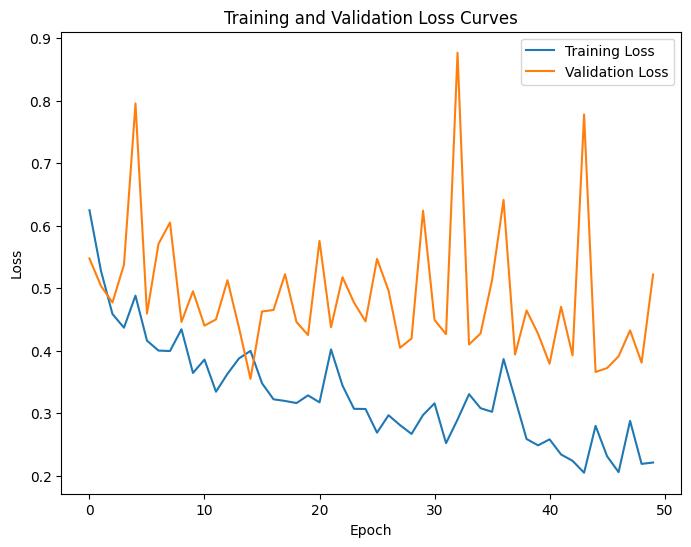

In [3]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

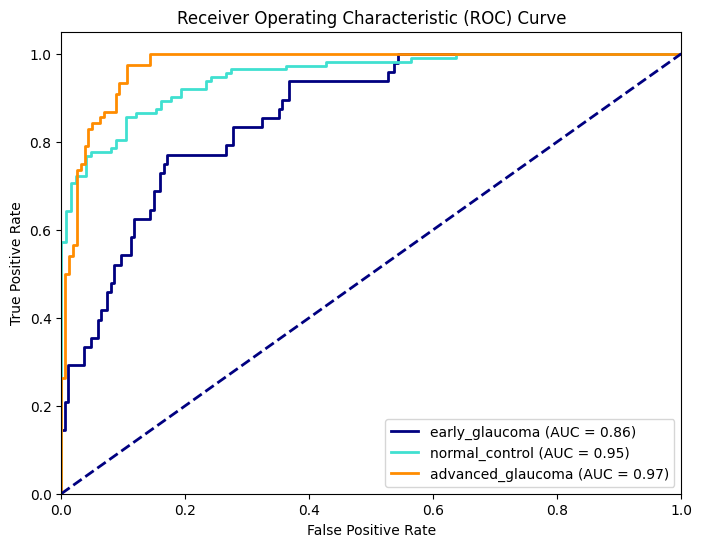

In [4]:
# Calculate ROC curve and AUC score
model.eval()
all_probabilities = []
all_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)  # Move input images to the same device as the model
        labels = labels.to(device)  # Move input labels to the same device as the model
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probabilities.extend(probabilities)
        all_labels.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score for each class
n_classes = len(class_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['navy', 'turquoise', 'darkorange'])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, [prob[i] for prob in all_probabilities])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

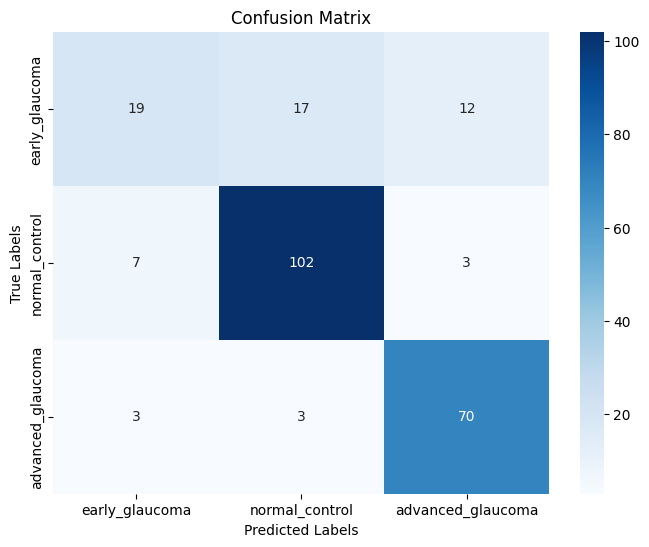

In [5]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()